<a href="https://colab.research.google.com/github/urosgodnov/juypterNotebooks/blob/main/DataMining/DataValidation_GreatExpectation_Advanced_topic_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data validation

## Preparing virtual environment - run only once

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!pip install virtualenv --quiet

In [ ]:
# creating virtual env. creates a new folder
!virtualenv "/tmp/colab_env"

In [ ]:
!source "/tmp/colab_env/bin/activate"

In [ ]:
!/tmp/colab_env/bin/pip install great-expectations==0.15.* "jinja2<3.1.0" pandas numpy --quiet

In [ ]:
!cp -r /tmp/colab_env /content/drive/MyDrive/

## Data validation

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import sys
sys.path.insert(0, "/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

import pandas as pd
import great_expectations as ge

### Parquet data files

A Parquet file is a columnar storage file format designed for efficient data processing and analytics. It organizes data by columns rather than rows, enabling faster queries for specific fields, reduced storage due to better compression, and improved performance for large-scale analytics tasks.

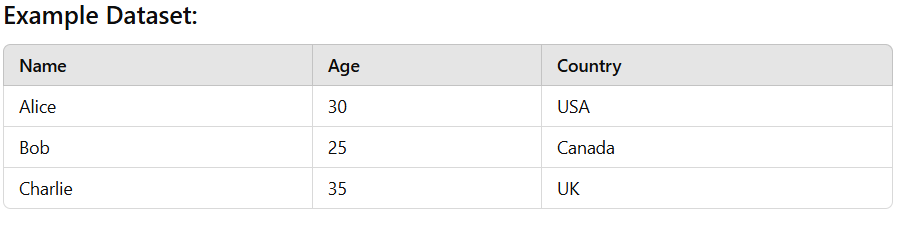

Row-based File (e.g., CSV):
Stored row by row:

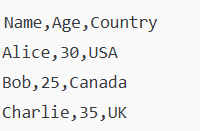


Columnar File (Parquet):
Stored column by column:

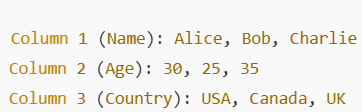

### Pandas method for reading parquet datafiles

In [ ]:
df=pd.read_parquet("/content/drive/MyDrive/Pandas_data/yellow_tripdata_2024-07.parquet")


In [ ]:
df.info()

## Data quality

accuracy, completeness, reliability, relevance, and timeliness

In [ ]:
df.describe().transpose()

**We have problems with data quality. We should expect only data for July, 2024, amounts, trip distance should be grater than 0, the problem is also with passengers' number.**

### Data cleansing

In [ ]:
passengers_filtered=df["passenger_count"].between(1,4)
df=df[passengers_filtered]

In [ ]:
keywords = ['amount', 'supercharge', 'fee', 'extra']
df=df[(df.filter(regex='|'.join(keywords)) >= 0).all(axis=1)]

In [ ]:
df.info()

In [ ]:
df.describe().transpose()

### Datetime manipulation

In [ ]:
# Filter for July 2024
df = df.loc[(df["tpep_pickup_datetime"].dt.month == 7) &
            (df["tpep_pickup_datetime"].dt.year == 2024)]

# Create new columns safely using .loc
df.loc[:, "pickup_date"] = df["tpep_pickup_datetime"].dt.date
df.loc[:, "pickup_time"] = df["tpep_pickup_datetime"].dt.time
df.loc[:, "dropoff_date"] = df["tpep_dropoff_datetime"].dt.date
df.loc[:, "dropoff_time"] = df["tpep_dropoff_datetime"].dt.time

df['duration_minutes'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60


In [ ]:
df = df.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'])

In [ ]:
df.head()

In [ ]:
df.describe().transpose()

In [ ]:
duration_filtered=df["duration_minutes"].between(5,120)
df=df[duration_filtered]

In [ ]:
df.info()

### Feature engineering

In [ ]:
df['pickup_dayofweek'] = pd.to_datetime(df['pickup_date']).dt.day_name()
df['pickup_hour_bucket'] = pd.cut(pd.to_datetime(df['pickup_time'], format='%H:%M:%S').dt.hour,
                                    bins=range(0, 24 + 2, 2),
                                    labels=[f'{i:02d}-{i+1:02d}' for i in range(0, 24, 2)],
                                    include_lowest=True, right=False)

### Quick analysis

In [ ]:
df[["passenger_count","duration_minutes"]].hist()

In [ ]:
import matplotlib.pyplot as plt

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['pickup_dayofweek'] = pd.Categorical(df['pickup_dayofweek'], categories=day_order, ordered=True)
df[['pickup_dayofweek',"pickup_hour_bucket"]].value_counts().unstack().plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend call outside of plot
plt.show() #add this to display the plot within your notebook.

## Great expectation

### Business problem

**Data is streaming regulary, how to check it**

**Great expectation**

Great Expectations is like a quality control tool for your data. It helps you automatically check whether your data looks and behaves the way you expect it to before you use it for analysis, machine learning, or any other purpose.

Think of it as a **spellchecker for your data**. Just like a spellchecker flags misspelled words in a document, Great Expectations flags issues in your data, such as missing values, wrong formats, or values outside expected ranges.

Key Concepts

1. Expectations:

These are like "rules" or "checks" you set up for your data. For example:
"The age column should only have numbers between 0 and 120."
"There shouldn't be any blank cells in the name column."
"The price column should always be greater than 0."
If the data breaks one of these rules, Great Expectations will let you know.

2. Validation:

This is the process where Great Expectations checks your data against the rules you've defined. If something doesn’t match, it tells you what's wrong.

3. Data Documentation:

Great Expectations creates a report showing you:
What rules were applied.
Which parts of your data passed or failed the checks.
This report is like a data health check, giving you confidence that your data is in good shape.

4. Automated Testing:

Instead of manually looking through your data for issues, Great Expectations does it automatically. This saves time and catches problems early.


**Why Is It Useful?**

- Prevents Errors: Stops you from working with bad data.
- Saves Time: Automatically checks for issues instead of you manually inspecting the data.
- Builds Trust: Gives you confidence that your data is reliable for decision-making or machine learning.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

target_site="/content/drive/MyDrive/colab_env/lib/python3.10/site-packages"

import sys
sys.path.insert(0,target_site)

import pandas as pd
import great_expectations as ge

In [ ]:
df1=pd.read_parquet("/content/drive/MyDrive/Pandas_data/yellow_tripdata_2024-07.parquet")

df_ge=ge.from_pandas(df1)

In [ ]:
df_ge.expect_column_values_to_be_between("passenger_count", 1, 4)
df_ge.expect_column_values_to_not_be_null("passenger_count")
df_ge.expect_column_values_to_be_between("payment_type", 1, 6)
df_ge.expect_column_values_to_not_be_null("payment_type")
df_ge.expect_column_values_to_be_between("RatecodeID", 1, 6)
df_ge.expect_column_values_to_not_be_null("RatecodeID")

In [ ]:
keywords = ['amount', 'supercharge', 'fee', 'extra']
amount_columns = df_ge.filter(regex='|'.join(keywords)).columns
for column in amount_columns:
    df_ge.expect_column_values_to_be_between(column, min_value=0, max_value=None)
    df_ge.expect_column_values_to_not_be_null(column)


In [ ]:
results = df_ge.validate()
print(results)

In [ ]:
from great_expectations.render.renderer import ValidationResultsPageRenderer
from great_expectations.render.view import DefaultJinjaPageView

# Render the validation results
renderer = ValidationResultsPageRenderer()
rendered_document = renderer.render(results)

# Convert the rendered document into an HTML string
rendered_html = DefaultJinjaPageView().render(rendered_document)

# Save the HTML to a file
report_path = "validation_report.html"
with open(report_path, "w") as f:
    f.write(rendered_html)
